In [186]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# Idees de resolutions
je vais essayer une approche croisee entre trois solutions : 
- Une random forest
- Un regression logistic
- Un reseau de neurones avec des calques denses assez simples

Dans l'idee je voudrais que les modeles aient des accuracy pas tres eloignes, et je ferai voter mes models pour la meilleure solution possible

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Analyse du dataset

In [3]:
df = pd.read_csv("data/train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


- survival -> Survival	0 = No, 1 = Yes
- pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- sex	Sex	
- Age	Age in years	
- sibsp	# of siblings / spouses aboard the Titanic	
- parch	# of parents / children aboard the Titanic	
- ticket	Ticket number	
- fare	Passenger fare	
- cabin	Cabin number	
- embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [10]:
df_survived = df.loc[df["Survived"] == 1, :]
df_dead = df.loc[df["Survived"] == 0, :]


## Missing Data

In [75]:
print("Age")
print("	Part of passengers with no information on the age", round((sum(df["Age"].isna()) /  df["Age"].shape[0]) * 100, 2),"%")
print("	Part of survived passengers with no information on the age", round((sum(df_survived["Age"].isna()) /  df_survived["Age"].shape[0]) * 100, 2),"%")
print("	Part of dead passengers with no information on the age", round((sum(df_dead["Age"].isna()) /  df_dead["Age"].shape[0]) * 100, 2),"%")

print()
print("Passenger Class")
print("	Part of passengers with no information on the Class", round((sum(df["Pclass"].isna()) /  df["Pclass"].shape[0]) * 100, 2),"%")

print()
print("Sex")
print("	Part of passengers with no information on the Sex", round((sum(df["Sex"].isna()) /  df["Sex"].shape[0]) * 100, 2),"%")

print()
print("Siblings spouses aboard the Titanic")
print("	Part of passengers with no information on the Siblings spouses aboard the Titanic", round((sum(df["SibSp"].isna()) /  df["SibSp"].shape[0]) * 100, 2),"%")

print()
print("Parents or children aboard the Titanic")
print("	Part of passengers with no information on the Parents or children aboard the Titanic", round((sum(df["Parch"].isna()) /  df["Parch"].shape[0]) * 100, 2),"%")

print()
print("Fare")
print("	Part of passengers with no information on the Fare", round((sum(df["Fare"].isna()) /  df["Fare"].shape[0]) * 100, 2),"%")

print()
print("Cabin")
print("	Part of passengers with no information on the Cabin", round((sum(df["Cabin"].isna()) /  df["Cabin"].shape[0]) * 100, 2),"%")
print("	Part of survived passengers with no information on the Cabin", round((sum(df_survived["Cabin"].isna()) /  df_survived["Cabin"].shape[0]) * 100, 2),"%")
print("	Part of dead passengers with no information on the Cabin", round((sum(df_dead["Cabin"].isna()) /  df_dead["Cabin"].shape[0]) * 100, 2),"%")

print()
print("Embarked")
print("	Part of passengers with no information on the Embarked", round((sum(df["Embarked"].isna()) /  df["Embarked"].shape[0]) * 100, 2),"%")



Age
	Part of passengers with no information on the age 19.87 %
	Part of survived passengers with no information on the age 15.2 %
	Part of dead passengers with no information on the age 22.77 %

Passenger Class
	Part of passengers with no information on the Class 0.0 %

Sex
	Part of passengers with no information on the Sex 0.0 %

Siblings spouses aboard the Titanic
	Part of passengers with no information on the Siblings spouses aboard the Titanic 0.0 %

Parents or children aboard the Titanic
	Part of passengers with no information on the Parents or children aboard the Titanic 0.0 %

Fare
	Part of passengers with no information on the Fare 0.0 %

Cabin
	Part of passengers with no information on the Cabin 77.1 %
	Part of survived passengers with no information on the Cabin 60.23 %
	Part of dead passengers with no information on the Cabin 87.61 %

Embarked
	Part of passengers with no information on the Embarked 0.22 %


There is too much missing data on the Cabin, I won't be using it now.

## Gender and Passenger Class

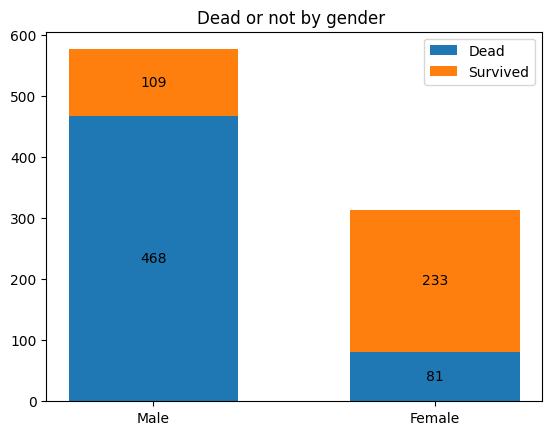

In [36]:
gender = ('Male', 'Female')
counts = {
    'Dead': np.array([ sum(df_dead["Sex"] == "male"), sum(df_dead["Sex"] == "female")]),
    'Survived': np.array([sum(df_survived["Sex"] == "male"), sum(df_survived["Sex"] == "female")]),
}
width = 0.6  # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
bottom = np.zeros(2)
for output, count in counts.items():
    p = ax.bar(gender, count, width, label=output, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Dead or not by gender ')
ax.legend()
plt.show()

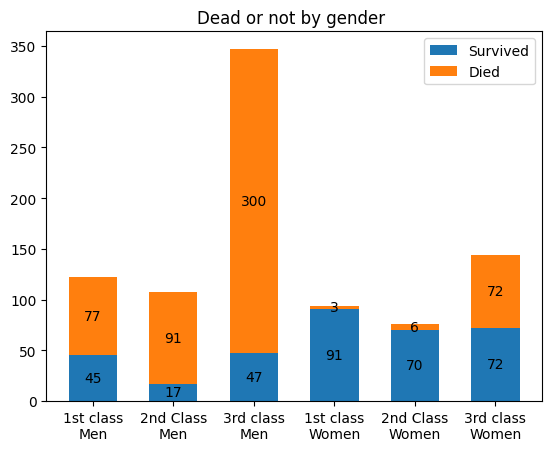

In [43]:
men_ok = df_survived[df_survived["Sex"] == "male"]
men_ko = df_dead[df_dead["Sex"] == "male"]
women_ok = df_survived[df_survived["Sex"] == "female"]
women_ko = df_dead[df_dead["Sex"] == "female"]

class_passenger = ('1st class\nMen', '2nd Class\nMen', "3rd class\nMen", '1st class\nWomen', '2nd Class\nWomen', "3rd class\nWomen")
counts = {
    'Survived': np.array([sum(men_ok["Pclass"] == 1),
                          sum(men_ok["Pclass"] == 2),
                          sum(men_ok["Pclass"] == 3),
                          sum(women_ok["Pclass"] == 1),
                          sum(women_ok["Pclass"] == 2),
                          sum(women_ok["Pclass"] == 3)]),
    'Died': np.array([sum(men_ko["Pclass"] == 1),
                      sum(men_ko["Pclass"] == 2),
                      sum(men_ko["Pclass"] == 3),
                      sum(women_ko["Pclass"] == 1),
                      sum(women_ko["Pclass"] == 2),
                      sum(women_ko["Pclass"] == 3)]),
}
width = 0.6
fig, ax = plt.subplots()
bottom = np.zeros(6)
for output, count in counts.items():
    p = ax.bar(class_passenger, count, width, label=output, bottom=bottom)
    bottom += count

    ax.bar_label(p, label_type='center')

ax.set_title('Dead or not by gender ')
ax.legend()
plt.show()

Obviously, gender and passenger class have a very strong impact on the likeliness to survive

## Age

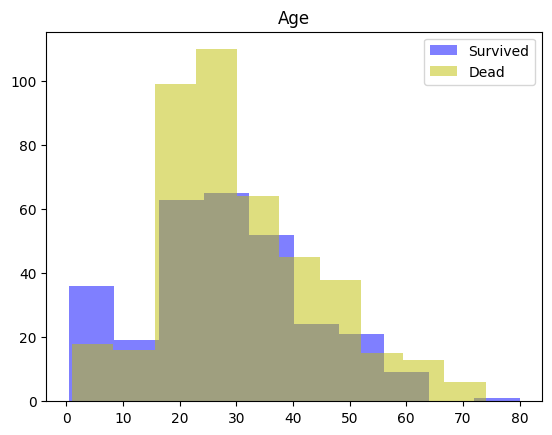

In [94]:
df_survived_with_age = df_survived.loc[df_survived["Age"].isna() == False]
df_dead_with_age = df_dead.loc[df_dead["Age"].isna() == False]

plt.title("Age")
plt.hist(df_survived_with_age.loc[:,"Age"], alpha = 0.5, lw=3, label="Survived", color="b")
plt.hist(df_dead_with_age.loc[:,"Age"], alpha = 0.5, lw=3, label="Dead", color="y")

plt.legend()
plt.show()

The age seems to have a strong impact on survival rate, estpecialy for young children, 20 to 30. I may try to train the model by replacing the missing age values by the mean of the dataset. Or by not using these values. 

# Fare

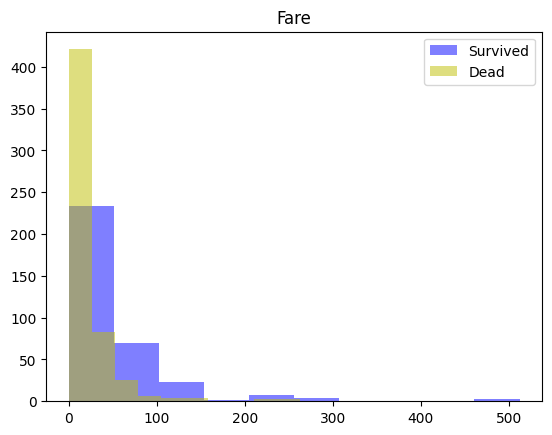

In [129]:
plt.title("Fare")
plt.hist(df_survived.loc[:,"Fare"], alpha = 0.5, lw=3, label="Survived", color="b")
plt.hist(df_dead.loc[:,"Fare"], alpha = 0.5, lw=3, label="Dead", color="y")

plt.legend()
plt.show()

### Embarked port

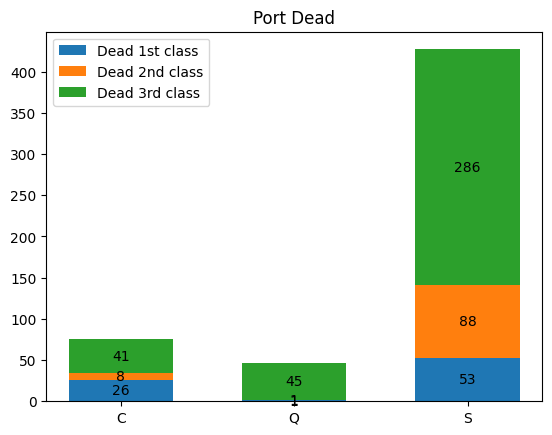

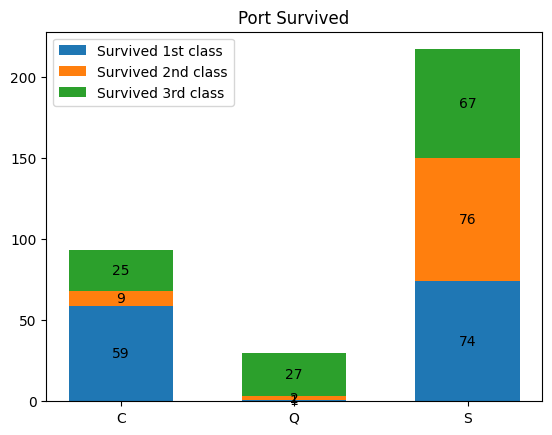

In [125]:
dead_c_1 = df.loc[(df["Embarked"] == "C") & (df["Pclass"] == 1) & (df["Survived"] == 0)].shape[0]
dead_c_2 = df.loc[(df["Embarked"] == "C") & (df["Pclass"] == 2) & (df["Survived"] == 0)].shape[0]
dead_c_3 = df.loc[(df["Embarked"] == "C") & (df["Pclass"] == 3) & (df["Survived"] == 0)].shape[0]
dead_q_1 = df.loc[(df["Embarked"] == "Q") & (df["Pclass"] == 1) & (df["Survived"] == 0)].shape[0]
dead_q_2 = df.loc[(df["Embarked"] == "Q") & (df["Pclass"] == 2) & (df["Survived"] == 0)].shape[0]
dead_q_3 = df.loc[(df["Embarked"] == "Q") & (df["Pclass"] == 3) & (df["Survived"] == 0)].shape[0]
dead_s_1 = df.loc[(df["Embarked"] == "S") & (df["Pclass"] == 1) & (df["Survived"] == 0)].shape[0]
dead_s_2 = df.loc[(df["Embarked"] == "S") & (df["Pclass"] == 2) & (df["Survived"] == 0)].shape[0]
dead_s_3 = df.loc[(df["Embarked"] == "S") & (df["Pclass"] == 3) & (df["Survived"] == 0)].shape[0]

survived_c_1 = df.loc[(df["Embarked"] == "C") & (df["Pclass"] == 1) & (df["Survived"] == 1)].shape[0]
survived_c_2 = df.loc[(df["Embarked"] == "C") & (df["Pclass"] == 2) & (df["Survived"] == 1)].shape[0]
survived_c_3 = df.loc[(df["Embarked"] == "C") & (df["Pclass"] == 3) & (df["Survived"] == 1)].shape[0]
survived_q_1 = df.loc[(df["Embarked"] == "Q") & (df["Pclass"] == 1) & (df["Survived"] == 1)].shape[0]
survived_q_2 = df.loc[(df["Embarked"] == "Q") & (df["Pclass"] == 2) & (df["Survived"] == 1)].shape[0]
survived_q_3 = df.loc[(df["Embarked"] == "Q") & (df["Pclass"] == 3) & (df["Survived"] == 1)].shape[0]
survived_s_1 = df.loc[(df["Embarked"] == "S") & (df["Pclass"] == 1) & (df["Survived"] == 1)].shape[0]
survived_s_2 = df.loc[(df["Embarked"] == "S") & (df["Pclass"] == 2) & (df["Survived"] == 1)].shape[0]
survived_s_3 = df.loc[(df["Embarked"] == "S") & (df["Pclass"] == 3) & (df["Survived"] == 1)].shape[0]

port = ('C', 'Q', 'S')
counts = {
    'Dead 1st class': np.array([dead_c_1, dead_q_1, dead_s_1]),
    'Dead 2nd class': np.array([dead_c_2, dead_q_2, dead_s_2]),
    'Dead 3rd class': np.array([dead_c_3, dead_q_3, dead_s_3]),
}
width = 0.6  # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
bottom = np.zeros(3)
for output, count in counts.items():
    p = ax.bar(port, count, width, label=output, bottom=bottom)
    bottom += count
    ax.bar_label(p, label_type='center')
ax.set_title('Port Dead')
ax.legend()
plt.show()

port = ('C', 'Q', 'S')
counts = {
    'Survived 1st class': np.array([survived_c_1, survived_q_1, survived_s_1]),
    'Survived 2nd class': np.array([survived_c_2, survived_q_2, survived_s_2]),
    'Survived 3rd class': np.array([survived_c_3, survived_q_3, survived_s_3]),
}
width = 0.6  # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
bottom = np.zeros(3)
for output, count in counts.items():
    p = ax.bar(port, count, width, label=output, bottom=bottom)
    bottom += count
    ax.bar_label(p, label_type='center')
ax.set_title('Port Survived')
ax.legend()
plt.show()

The ratio of survived and death is not the same for each port. This probably has an influence on the final result. 

# Transforming the Dataset

In [127]:
df.drop(columns=["Name", "Ticket", "Cabin"], inplace=True)

In [135]:
df["Cherbourg"] = (df["Embarked"] == "C").transform(lambda x : int(x))

In [137]:
df["Queenstown"] = (df["Embarked"] == "Q").transform(lambda x : int(x))
df["Southampton"] = (df["Embarked"] == "S").transform(lambda x : int(x))

In [139]:
df["Male"] = (df["Sex"] == "male").transform(lambda x : int(x))
df["Female"] = (df["Sex"] == "female").transform(lambda x : int(x))

In [148]:
df["1_Class"] = (df["Pclass"] == 1).transform(lambda x : int(x))
df["2_Class"] = (df["Pclass"] == 2).transform(lambda x : int(x))
df["3_Class"] = (df["Pclass"] == 3).transform(lambda x : int(x))

In [150]:
df.drop(columns=["Sex", "Embarked", "Pclass"], inplace=True)

In [152]:
df

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cherbourg,Queenstown,Southampton,Male,Female,1_Class,2_Class,3_Class
0,1,0,22.0,1,0,7.2500,0,0,1,1,0,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,0,1,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,1,0,1,0,0,1
3,4,1,35.0,1,0,53.1000,0,0,1,0,1,1,0,0
4,5,0,35.0,0,0,8.0500,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,27.0,0,0,13.0000,0,0,1,1,0,0,1,0
887,888,1,19.0,0,0,30.0000,0,0,1,0,1,1,0,0
888,889,0,NaN,1,2,23.4500,0,0,1,0,1,0,0,1
889,890,1,26.0,0,0,30.0000,1,0,0,1,0,1,0,0


In [183]:
#Il faut normaliser Fare
df.isnull().sum()

PassengerId      0
Survived         0
Age            177
SibSp            0
Parch            0
Fare             0
Cherbourg        0
Queenstown       0
Southampton      0
Male             0
Female           0
1_Class          0
2_Class          0
3_Class          0
dtype: int64

In [185]:
df_age_removed = df.copy()
df_age_removed = df_age_removed.loc[df_age_removed["Age"].isnull() == False,:]
df_age_removed.isnull().sum()

PassengerId    0
Survived       0
Age            0
SibSp          0
Parch          0
Fare           0
Cherbourg      0
Queenstown     0
Southampton    0
Male           0
Female         0
1_Class        0
2_Class        0
3_Class        0
dtype: int64

# Modeles

In [187]:
class SimpleLogisticRegression(nn.Module):
	"""
	My simple logistic regression model
	"""
	def __init__(self, input_size, output_size=1) -> None:
		super(SimpleLogisticRegression, self).__init__()
		self.linear = nn.Linear(input_size, output_size)

	def forward(self, x):
		result = self.linear(x)
		return torch.sigmoid(result)

In [188]:
class SimpleNeuralNetwork(nn.Module):
	"""
	A simple Neural Network
	"""
	def __init__(self, input_size, output_size=1, hidden_layer_size=32) -> None:
		super(SimpleNeuralNetwork, self).__init__()
		self.hidden_1 = nn.Linear(input_size, hidden_layer_size)
		self.outputLayer = nn.Linear(hidden_layer_size, output_size)
	
	def forward(self, x):
		x = torch.sigmoid(self.hidden_1(x))
		return torch.sigmoid(self.outputLayer(x))
